In [39]:
# imports
import tueplots
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "djnaq95k"


In [20]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [21]:
summary_list, config_list, name_list, sigmas = [], [], [], []
for run in sweep_runs:

    if f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)



        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        sigmas.append(run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(config_list[-1]['latent_dim'])]).iloc[-1].to_numpy()[1:])


        # .name is the human-readable name of the run.
        name_list.append(run.name)



runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "sigmas" : sigmas
    })

runs_df.to_csv("project.csv")

In [5]:
runs_df.head()

,summary,config,name
0,{'Metrics/val/sample_col_max_norms': [[0.12357...,"{'lr': 0.001, 'beta': 1, 'dims': 'None', 'seed...",solar-sweep-144
1,{'gradients/model.encoder.fc.1.weight': {'_typ...,"{'lr': 0.001, 'beta': 1, 'dims': 'None', 'seed...",rich-sweep-143


In [38]:
data = [ (summary['Metrics/val/mcc'], summary['Metrics/val/cima'], config['latent_dim'], config['decoder_var'], config['model.prior'],summary['Metrics/val/col_norms'], sigma) for summary, config, sigma in zip(runs_df['summary'], runs_df['config'], runs_df['sigmas'])]

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [37]:
runs_df.config.iloc[0].keys()

dict_keys(['lr', 'beta', 'dims', 'seed', 'angle', 'n_obs', 'prior', 'shape', 'affine', 'deltah', 'deltas', 'deltav', 'device', 'linear', 'mobius', 'orthog', 'ar_flow', 'dataset', 'data_dir', 'n_layers', 'fix_prior', 'n_classes', 'prior_var', 'val_ratio', 'activation', 'batch_size', 'latent_dim', 'n_segments', 'prior_beta', 'prior_mean', 'projective', 'decoder_var', 'log_latents', 'model.prior', 'prior_alpha', 'train_ratio', 'break_orthog', 'synth_source', 'mixing_layers', 'diag_posterior', 'val_transforms', 'seed_everything', 'test_transforms', 'model.latent_dim', 'train_transforms', 'data.synth_source', 'model.decoder_var', 'log_reconstruction'])

In [83]:
gamma_sq = [np.array(1./d[3]) for d in data]
prior = [d[4] for d in data]
col_norm_sq = [d[5] for d in data]
sigmas = runs_df.sigmas.to_numpy()
mcc = np.array([d[0] for d in data])
cima = np.array([d[1] for d in data])
dim = np.array([d[2] for d in data])

In [84]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

In [70]:
lhs_gauss = [s for s,p in zip(sigmas,prior) if p == "gaussian"]
rhs_gauss = [1./(1+g*J) for g, J, p in zip(gamma_sq, col_norm_sq, prior) if p == "gaussian"]
gamma_gauss = [g for g,p in zip(ext_gamma_sq, prior) if p == "gaussian"]

lhs_laplace = [s for s,p in zip(sigmas,prior) if p == "laplace"]
rhs_laplace = [1./(g*J) for g, J, p in zip(gamma_sq, col_norm_sq, prior) if p == "laplace"]

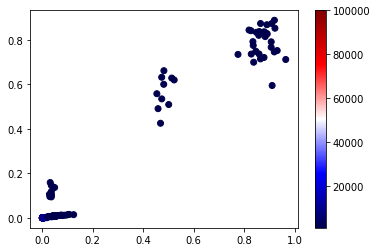

In [76]:
plt.scatter(np.concatenate(lhs_gauss), np.concatenate(rhs_gauss), c=np.concatenate(gamma_gauss), cmap='seismic', )
plt.colorbar()

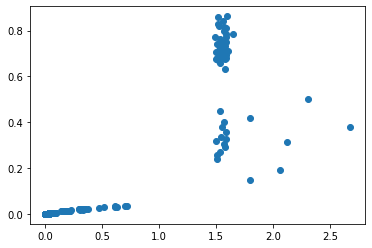

In [62]:
plt.scatter(np.concatenate(lhs_laplace), np.concatenate(rhs_laplace))

In [91]:
cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]
mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]

In [87]:
len(cima_vs_dim)

4

{'bodies': [<matplotlib.collections.PolyCollection at 0x11c4c36d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11c515310>,
 'cmins': <matplotlib.collections.LineCollection at 0x11c523340>,
 'cbars': <matplotlib.collections.LineCollection at 0x11c5236a0>}

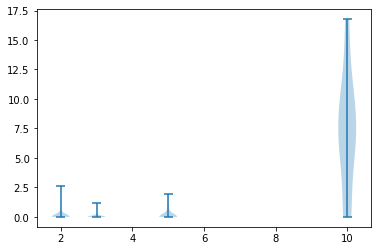

In [90]:
plt.violinplot(cima_vs_dim, positions=np.unique(np.array(dim)))

{'bodies': [<matplotlib.collections.PolyCollection at 0x11c4c31f0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11c56da30>,
 'cmins': <matplotlib.collections.LineCollection at 0x11c59cdf0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11c5a91f0>}

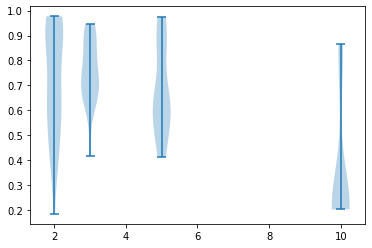

In [92]:
plt.violinplot(mcc_vs_dim, positions=np.unique(np.array(dim)))